In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [25]:
# D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

D1    = loadmat("../datasets/descriptors/SFUMountain/dry/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/SFUMountain/dusk/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/SFUMountain/dry--dusk/gt.mat")


# Generate a random projection matrix
np.random.seed(42)  # for reproducibility
projection_matrix = np.random.randn(4096, 1024)

# Normalize the columns of the projection matrix
projection_matrix /= np.linalg.norm(projection_matrix, axis=0)

# Project D1 and D2
D1_projected = np.dot(D1, projection_matrix)
D2_projected = np.dot(D2, projection_matrix)



In [26]:
normalizer = Normalizer()

mu1 = np.mean(D1,axis=0)

dbVectors_centered = np.subtract(D1,mu1)

dbVectors_norm = normalizer.fit_transform(dbVectors_centered)

In [48]:
from dot_product import  LoihiDotProductSimulationPositive, LoihiDotProductSimulationPositiveDBScale


In [39]:
constant = 1/math.sqrt(2)

dot = LoihiDotProductSimulationPositiveDBScale(D1_projected, D2_projected, constant, timesteps=50, dbScale=1)


In [40]:
DD, qs, dbs = dot.run()

queryVector :
[[ -9.60154937  -7.29992288  14.44372555 ...  28.54796863  -8.17163354  27.03703767]
 [ 18.20624944 -21.76751051  -4.73185445 ...   9.05848377 -28.88244337  28.57207358]
 [-11.70135835 -12.58921353  16.08116106 ...  12.75966923   1.43781864  25.34199552]
 ...
 [ -8.39850018  10.2106349  -57.24620977 ...  20.77976709  10.8025142   20.47811911]
 [  9.92013531   1.35166295 -21.91968332 ...   8.23369808  14.84516166  -3.73591864]
 [-46.40170481  -1.67731482  14.76488726 ... -53.63024389  -4.16275061  74.79577034]]
mean_center_norm_positive :
[[0.70951828 0.71623166 0.6954597  ... 0.76976338 0.7198077  0.74759547]
 [0.7535795  0.69368397 0.66471441 ... 0.7412139  0.68751686 0.75148991]
 [0.70633814 0.70812765 0.69823867 ... 0.74448864 0.73363425 0.74384808]
 ...
 [0.71092393 0.73932237 0.59831948 ... 0.75276231 0.74454341 0.73449855]
 [0.73386009 0.72565614 0.65132856 ... 0.7334058  0.74683947 0.7017295 ]
 [0.66244662 0.72181853 0.69783619 ... 0.65496467 0.72274368 0.80130959]

100%|██████████| 385/385 [01:44<00:00,  3.70it/s]


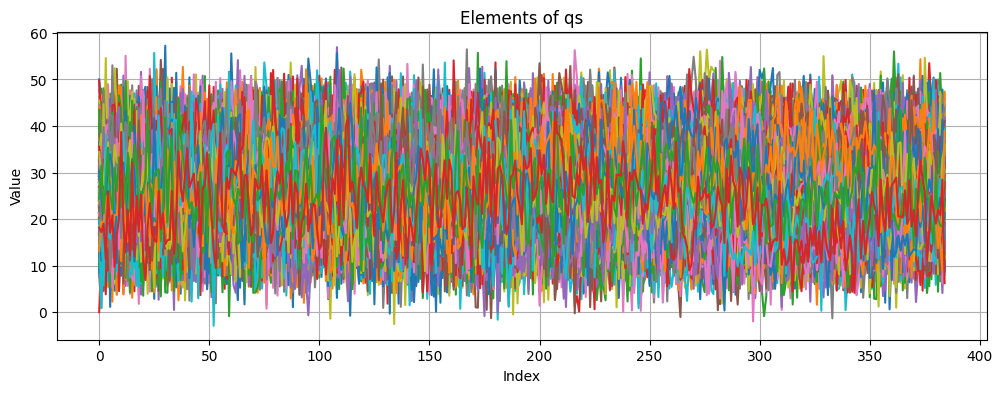

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(qs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

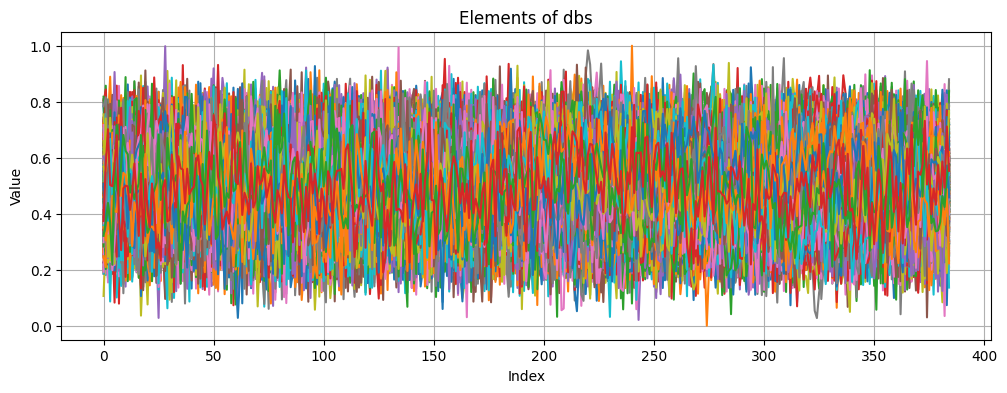

In [42]:
plt.figure(figsize=(12, 4))
plt.plot(dbs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [43]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(qs, dbs.T)  # This will give a 200x200 matrix

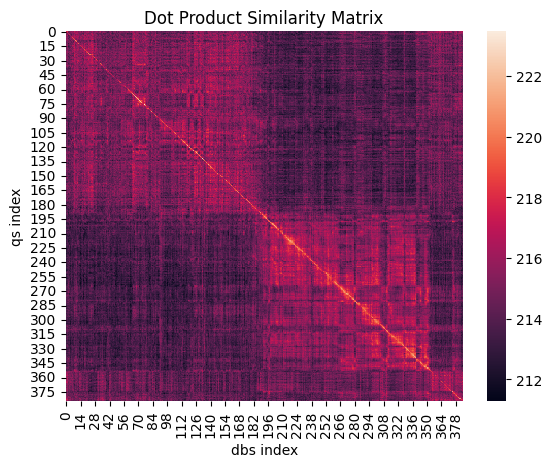

In [44]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix/2**6)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

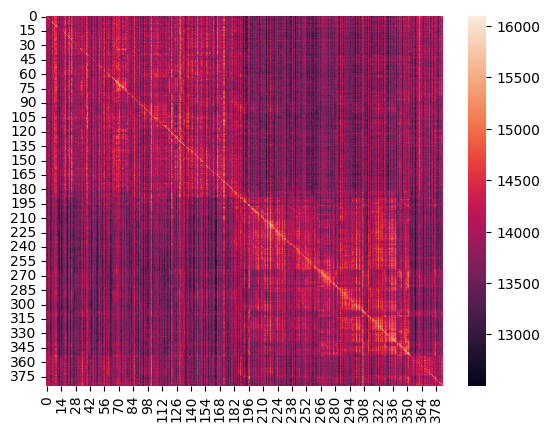

In [45]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [46]:

metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")

# You can also access other metrics if needed:
# print(f"Recalls: {metrics['recalls']}")
# print(f"Precision: {metrics['precision']}")
# print(f"Recall: {metrics['recall']}")

AUC: 0.39501442626452477


In [35]:
0.6748171536626169


0.6748171536626169